In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

# Load data
df = pd.read_csv('data.csv', sep=';')
X = df.drop(['Class', 'Output'], axis=1)
y = df['Class']

### Approach

I started with defining a function for model evaluation and then experimented with different preprocessing and model combos. Below is a short summary of my findings.

In [65]:
# Model evaluation framework
def evaluate_model(model, X, y, cv_folds=5, model_name="Model"):
    """Comprehensive model evaluation function"""
    # Stratified K-Fold for balanced splits
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    
    # Fit model for training accuracy
    model.fit(X, y)
    train_pred = model.predict(X)
    train_accuracy = accuracy_score(y, train_pred)
    
    # Results
    results = {
        'model_name': model_name,
        'train_accuracy': train_accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'cv_scores': cv_scores,
        'overfitting': train_accuracy - cv_scores.mean()
    }
    
    print(f"Model: {model_name}")
    print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
    print(f"CV Mean Accuracy:  {cv_scores.mean():.4f} ({cv_scores.mean()*100:.2f}%)")
        
    return results

## Model Evaluation Summary

I explored several approaches to improve the baseline model's performance:

| Model | CV Accuracy | Improvement |
|-------|------------|-------------|
| Baseline Logistic Regression | 52.4% | Baseline |
| Logistic Regression + SelectKBest | 61.1% | +8.7% |
| SVC (RBF) + SelectKBest | 67.5% | +15.1% |
| Random Forest | 66.1% | +13.7% |
| Random Forest + SelectKBest | 73.6% | +21.2% |
| Optimized Random Forest + SelectKBest | 74.9% | +22.5% |
| Random Forest + PCA + Lasso | 65.3% | +12.9% |
| **Random Forest + RFE** | **78.8%** | **+26.4%** |


I got very promising results with Random Forest Classifier and Recursive Feature Elimination. I decided to stick with this approach and tune the model.

## Fine-tuning the Best Model

To further improve my best model (Random Forest with RFE), I'll focus on two key optimization strategies:

1. **Optimal Feature Count**: Find the ideal number of features for RFE to select
2. **Hyperparameter Tuning**: Fine-tune the Random Forest parameters

These optimizations may provide incremental improvements to already strong model.

In my previous experiments, I achieved promising results for small number of features, around 20.


Testing RFE with 10 features...
Model: RF + RFE (10 features)
Training Accuracy: 1.0000 (100.00%)
CV Mean Accuracy:  0.7950 (79.50%)
CV Scores: ['0.8150', '0.8075', '0.7850', '0.7900', '0.7775']

Testing RFE with 12 features...
Model: RF + RFE (12 features)
Training Accuracy: 1.0000 (100.00%)
CV Mean Accuracy:  0.8100 (81.00%)
CV Scores: ['0.8300', '0.8025', '0.8075', '0.8050', '0.8050']

Testing RFE with 14 features...
Model: RF + RFE (14 features)
Training Accuracy: 1.0000 (100.00%)
CV Mean Accuracy:  0.8145 (81.45%)
CV Scores: ['0.8375', '0.8125', '0.7975', '0.8025', '0.8225']

Testing RFE with 16 features...
Model: RF + RFE (16 features)
Training Accuracy: 1.0000 (100.00%)
CV Mean Accuracy:  0.8120 (81.20%)
CV Scores: ['0.8400', '0.8050', '0.8025', '0.8025', '0.8100']

Testing RFE with 18 features...
Model: RF + RFE (18 features)
Training Accuracy: 1.0000 (100.00%)
CV Mean Accuracy:  0.8130 (81.30%)
CV Scores: ['0.8375', '0.8125', '0.7950', '0.8050', '0.8150']

Testing RFE with 20

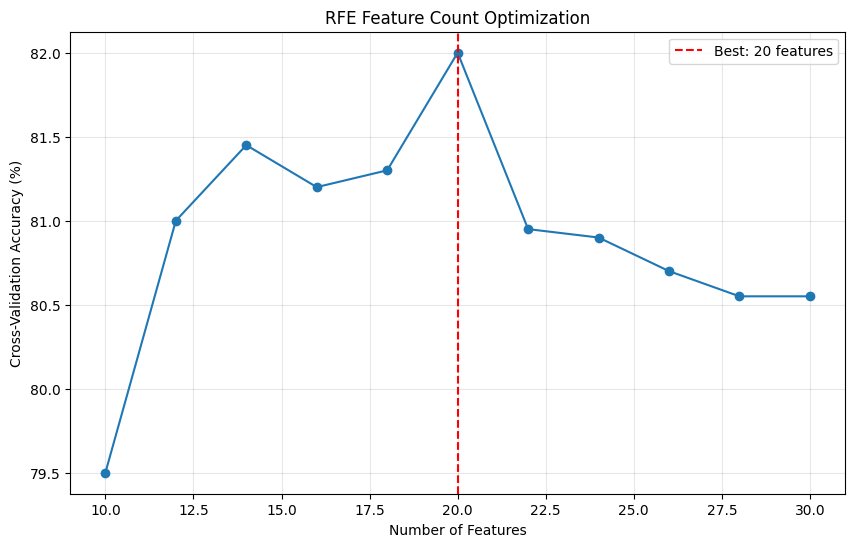


Optimal features selected: ['Input2', 'Input38', 'Input40', 'Input41', 'Input65', 'Input74', 'Input95', 'Input101', 'Input110', 'Input137', 'Input150', 'Input206', 'Input238', 'Input240', 'Input246', 'Input256', 'Input293', 'Input308', 'Input330', 'Input396']


In [62]:
# 1. Find optimal number of features for RFE

# Test a range of feature counts
feature_range = [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
rfe_results = {}

for n_features in feature_range:
    print(f"\nTesting RFE with {n_features} features...")
    
    # Create RFE with specified number of features
    rfe_test = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), 
                  n_features_to_select=n_features, step=10, verbose=0)
    X_rfe_test = rfe_test.fit_transform(X, y)
    
    # Create and evaluate model (these parameters are kind of randomly chosen, I will optimize them later)
    rf_test = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )
    
    # Use cross-validation for more reliable results
    cv_results = evaluate_model(rf_test, X_rfe_test, y, model_name=f"RF + RFE ({n_features} features)")
    rfe_results[n_features] = cv_results

# Find best feature count
feature_counts = list(rfe_results.keys())
cv_means = [rfe_results[n]['cv_mean'] for n in feature_counts]
best_feature_count = feature_counts[np.argmax(cv_means)]
best_cv_mean = max(cv_means)

print(f"\nBest feature count: {best_feature_count} with CV accuracy: {best_cv_mean:.4f} ({best_cv_mean*100:.2f}%)")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, [score*100 for score in cv_means], marker='o', linestyle='-')
plt.axvline(x=best_feature_count, color='r', linestyle='--', label=f'Best: {best_feature_count} features')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation Accuracy (%)')
plt.title('RFE Feature Count Optimization')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Use the best feature count for further optimization
optimal_rfe = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), 
                  n_features_to_select=best_feature_count, step=10, verbose=0)
X_rfe_optimal = optimal_rfe.fit_transform(X, y)

# Get feature names
optimal_feature_indices = np.where(optimal_rfe.ranking_ == 1)[0]
optimal_feature_names = X.columns[optimal_feature_indices]
print(f"\nOptimal features selected: {optimal_feature_names.tolist()}")

In [63]:
# 2. Hyperparameter optimization for Random Forest

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Set up grid search with cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_rfe_optimal, y)

# Print best parameters and score
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f} ({grid_search.best_score_*100:.2f}%)")

# Get best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits

Best parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.8270 (82.70%)


The best accuracy I was able to achieve was 82,7%. Let's test this model one final time with high number of folds, to demonstrate that it is not prone to overfitting.

In [66]:
# Evaluate best model
evaluate_model(best_rf, X_rfe_optimal, y, cv_folds=50, model_name="Fully Optimized RF + RFE")

Model: Fully Optimized RF + RFE
Training Accuracy: 1.0000 (100.00%)
CV Mean Accuracy:  0.8275 (82.75%)


{'model_name': 'Fully Optimized RF + RFE',
 'train_accuracy': 1.0,
 'cv_mean': np.float64(0.8275),
 'cv_std': np.float64(0.06368869601428498),
 'cv_scores': array([0.825, 0.875, 0.8  , 0.8  , 0.85 , 0.95 , 0.925, 0.825, 0.9  ,
        0.8  , 0.825, 0.8  , 0.875, 0.775, 0.725, 0.875, 0.9  , 0.85 ,
        0.875, 0.75 , 0.875, 0.775, 0.85 , 0.9  , 0.825, 0.875, 0.85 ,
        0.775, 0.825, 0.625, 0.75 , 0.875, 0.75 , 0.725, 0.85 , 0.75 ,
        0.875, 0.85 , 0.8  , 0.9  , 0.85 , 0.925, 0.8  , 0.775, 0.85 ,
        0.75 , 0.825, 0.9  , 0.875, 0.725]),
 'overfitting': np.float64(0.1725)}

Although the difference between train and cv accuracy is high, this is normal for Random Forest. High cv mean suggests that the model generalizes the data well.